In [103]:
import praw
import prawcore
import pandas as pd
import numpy as np 
import os
import re
import math

from tqdm import tqdm
from datetime import datetime, date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, precision_recall_curve
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt

import statsmodels.api as sm


# from spacy import load
# import warnings
# warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

In [2]:
path = 'data/user_data'

In [57]:
def data_parser(infile_name):

    path = 'data/user_data'

    df = pd.read_csv(f'{path}/{infile_name}')
    bot_substrings = ['bot', 'b0t']
    df['heuristic'] = 0
    df['username'] = df['username'].str.lower()


    for ind in df.index:
        if any(x in df['username'][ind] for x in bot_substrings):
            df['heuristic'][ind] = 1
        elif pd.to_timedelta(df['avg_reply_speed'][ind]) < pd.to_timedelta('0 days 00:05:00'):
            df['heuristic'][ind] = 1
        elif pd.to_timedelta(df['avg_comment_time_interval'][ind]) < pd.to_timedelta('0 days 00:05:00'):
            df['heuristic'][ind] = 1
        elif df['avg_comment_similarity'][ind] >= .8 or df['avg_comment_similarity'][ind] <= .1:
            df['heuristic'][ind] = 1
        elif df['karma_ratio'][ind] < .15:
            df['heuristic'][ind] = 1
        else:
            df['heuristic'][ind] = 0
    df['heuristic'].value_counts()
    return df

In [89]:
df_sus = data_parser('suspected_bots.csv')

C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 0
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 1
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 1
C:\Users\ray\AppData\Local\T

In [97]:
df_all = data_parser('all_bots.csv')

C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 0
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 1
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/2199117663.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bot_score'][ind] = 1
C:\Users\ray\AppData\Local\T

In [119]:
df_sus

,Unnamed: 0,username,comment_karma,submission_karma,karma_ratio,avg_comment_similarity,avg_toxicity,avg_reply_speed,avg_comment_time_interval,bot_score
0,0,grandmink,600,816,0.7353,0.663183,0.104107,0 days 00:05:08,2 days 03:54:57,0
1,1,independent_day7209,212,5200,0.0408,0.388920,0.029127,0 days 00:21:39,0 days 08:07:21,1
2,2,warmbicycle8961,5,1,5.0000,0.514270,0.292615,0 days 02:08:21,48 days 14:34:49,0
3,3,flimsy-insurance-978,102,1,102.0000,0.335881,0.106027,0 days 03:30:24,0 days 00:00:37,1
4,4,markjug67,3,1,3.0000,0.389103,0.008184,0 days 04:10:41,0 days 00:19:51,0
...,...,...,...,...,...,...,...,...,...,...
886,886,real_market8974,83,1,83.0000,0.429026,0.036792,0 days 00:44:24,6 days 01:50:22,0
887,887,false-attemp,1071,1911,0.5604,0.520226,0.012752,0 days 03:03:07,5 days 17:44:08,0
888,888,plane-kale-7588,42,1,42.0000,0.144107,0.000723,0 days 01:34:57,5 days 13:07:20,0
889,889,dogdry7071,287,1,287.0000,-0.072151,0.216564,0 days 00:53:38,11 days 23:41:52,1


In [113]:
def feature_extraction(df):
    df_copy = df.copy()
#     df_copy.drop(columns=['avg_toxicity'])
    for ind in df_copy.index:
        df_copy['avg_comment_time_interval'][ind] = float(pd.to_timedelta(df_copy['avg_comment_time_interval'][ind]).total_seconds())
        df_copy['avg_reply_speed'][ind] = float(pd.to_timedelta(df_copy['avg_reply_speed'][ind]).total_seconds())
    
    usernames = df_copy.values[:, 1]
    comment_karma = df_copy.values[:, 2]
    submission_karma = df_copy.values[:, 3]
    karma_ratio = df_copy.values[:, 4]
    comment_similarity = df_copy.values[:, 5]
    toxicity = df_copy.values[:, 6]
    reply_speed = df_copy.values[:, 7]
    time_interval = df_copy.values[:, 8]
    heuristics = df_copy.values[:, 9]

    features = df_copy.values[:, 2:10]
    labels = df_copy.values[:, 10]
    
    return features, labels

In [136]:
def train_df(df):
    features, labels = feature_extraction(df)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=104, test_size=.2, shuffle=True)
    
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    

    clf = LogisticRegression()

    clf.fit(X_train, y_train)
    print('Coefficients: \n', clf.coef_)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    return y_pred, y_test, y_score
 

In [175]:
def train_for_logit_df(df):
    features, labels = feature_extraction(df)
    

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=104, test_size=.2, shuffle=True)
    
    X_test = X_test.astype(np.float64)
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    column_name = ["comment_karma", "submission_karma", "karma_ratio", "avg_comment_similarity", "avg_toxicity", "avg_reply_speed","avg_comment_time_interval", "heuristic"]
    

    logit_model=sm.Logit(y_train, X_train)
    result=logit_model.fit()
    
    
    
    print(result.summary(xname=column_name))
    
    probabilities  = result.predict(X_test)
    y_pred = (probabilities >= 0.5).astype(int)
    
    with open(f'summary.txt', 'w') as fh:
        fh.write(result.summary(xname=column_name).as_text())
    
    return y_pred, y_test, probabilities
 

In [21]:
def matrix(y_test, y_pred, cmap='Blues'):
    matrix = confusion_matrix(y_test, y_pred)


    classes = ['Not Bot', 'Bot']

    plt.matshow(matrix, cmap=cmap)
    plt.title('Suspected Bot Predictions')
#     plt.colorbar()
    plt.clim(0,120)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')

    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, matrix[i, j], ha='center', va='center')
    
    plt.savefig("confusion_matrix.png", dpi=600)

In [174]:
y_pred_sus, y_test_sus, y_score_sus = train_for_logit_df(df_sus)

C:\Users\ray\AppData\Local\Temp/ipykernel_19460/979684982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['avg_comment_time_interval'][ind] = float(pd.to_timedelta(df_copy['avg_comment_time_interval'][ind]).total_seconds())
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/979684982.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['avg_reply_speed'][ind] = float(pd.to_timedelta(df_copy['avg_reply_speed'][ind]).total_seconds())


Optimization terminated successfully.
         Current function value: 0.617708
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                 0.09010
Time:                        19:28:20   Log-Likelihood:                -439.81
converged:                       True   LL-Null:                       -483.36
Covariance Type:            nonrobust   LLR p-value:                 1.210e-16
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
comment_karma                -0.0069      0.001     -5.870      0.000      -0.

C:\Users\ray\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [98]:
y_pred_all, y_test_all, y_score_all = train_df(df_all)

C:\Users\ray\AppData\Local\Temp/ipykernel_19460/4101885825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['avg_comment_time_interval'][ind] = float(pd.to_timedelta(df_copy['avg_comment_time_interval'][ind]).total_seconds())
C:\Users\ray\AppData\Local\Temp/ipykernel_19460/4101885825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['avg_reply_speed'][ind] = float(pd.to_timedelta(df_copy['avg_reply_speed'][ind]).total_seconds())


Coefficients: 
 [[-3.12295281e-07  2.60868967e-06  3.38121425e-04  3.00314784e-08
   2.39139641e-09 -6.35274984e-09 -1.31296356e-08]]


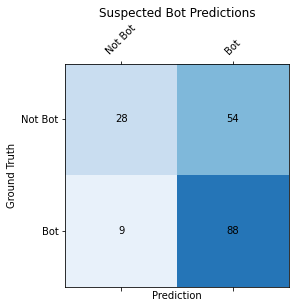

In [142]:
matrix(y_test_sus, y_pred_sus)

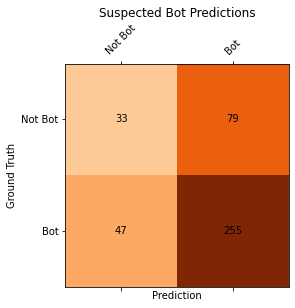

In [99]:
matrix(y_test_all, y_pred_all, cmap="Oranges")

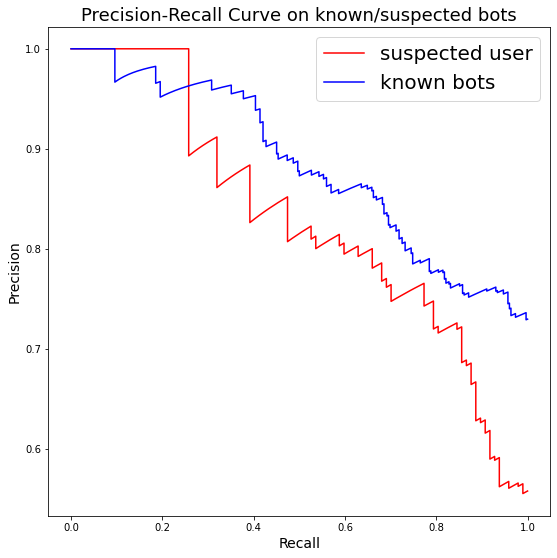

In [143]:
precision_sus, recall_sus, thresholds_sus = precision_recall_curve(y_test_sus, y_score_sus)
precision_all, recall_all, thresholds_all = precision_recall_curve(y_test_all, y_score_all)

plt.figure(figsize=(9, 9))
plt.plot(recall_sus, precision_sus, 'r', label='suspected user')
plt.plot(recall_all, precision_all, 'b', label='known bots')
leg = plt.legend(prop={'size': 20})
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.title("Precision-Recall Curve on known/suspected bots", fontsize=18)
plt.show()

In [144]:
auc(recall_sus, precision_sus)

0.8291658737645498

In [13]:
pairs = {'recall_sus': recall_sus, 'precision_sus': precision_sus}

precision_sus_df = pd.DataFrame.from_dict(pairs)

precision_sus_df.to_csv('precision_sus_df.csv', index = False)